I am using YOLOv2 to detect Pneumonia in chext x-ray images. I am using a DenseNet121 model pretrained on ChestX-ray14 dataset (ChexNet) for feature extraction before the YOLO detection layer.
Credits: code that helped me in the kernel
1. loading dicom images
https://www.kaggle.com/jonnedtc/cnn-segmentation-connected-components
2. YOLOv2 implementation
https://github.com/experiencor/keras-yolo2
3. Weights for a pretrained ChexNet model
https://github.com/brucechou1983/CheXNet-Keras

In [1]:
import random
import numpy as np 
import pandas as pd
import os
import pydicom
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.transform import resize
from keras.utils import Sequence
from keras.applications.densenet import DenseNet121
from keras.layers import Input, Activation, Conv2D, Reshape, Lambda, Dense, AveragePooling2D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import tensorflow as tf
from skimage.exposure import equalize_hist
from keras.utils import to_categorical

/usr/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

def IOU(ann, centroids):
    w, h = ann
    similarities = []
    for centroid in centroids:
        c_w, c_h = centroid
        if c_w >= w and c_h >= h:
            similarity = w*h/(c_w*c_h)
        elif c_w >= w and c_h <= h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
        elif c_w <= w and c_h >= h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
        else: #means both w,h are bigger than c_w and c_h respectively
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape

    return np.array(similarities)

def avg_IOU(anns, centroids):
    n,d = anns.shape
    sum = 0.
    for i in range(anns.shape[0]):
        sum+= max(IOU(anns[i], centroids))
    return sum/n

def run_kmeans(ann_dims, anchor_num):
    ann_num = ann_dims.shape[0]
    iterations = 0
    prev_assignments = np.ones(ann_num)*(-1)
    iteration = 0
    old_distances = np.zeros((ann_num, anchor_num))

    indices = [random.randrange(ann_dims.shape[0]) for i in range(anchor_num)]
    centroids = ann_dims[indices]
    anchor_dim = ann_dims.shape[1]

    while True:
        distances = []
        iteration += 1
        for i in range(ann_num):
            d = 1 - IOU(ann_dims[i], centroids)
            distances.append(d)
        distances = np.array(distances) # distances.shape = (ann_num, anchor_num)
        
        #assign samples to centroids
        assignments = np.argmin(distances,axis=1)

        if (assignments == prev_assignments).all() :
            return centroids

        #calculate new centroids
        centroid_sums=np.zeros((anchor_num, anchor_dim), np.float)
        for i in range(ann_num):
            centroid_sums[assignments[i]]+=ann_dims[i]
        for j in range(anchor_num):
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j) + 1e-6)

        prev_assignments = assignments.copy()
        old_distances = distances.copy()

In [3]:
model_no = '40'
path = '/home/amr/data/'
RESIZE_SCALE = 448/1024.

INPUT_SIZE = 448

# read the labels and resize the height and width
labels = pd.read_csv(path+'stage_1_train_labels.csv')
width = labels['width'].dropna()*RESIZE_SCALE
height = labels['height'].dropna()*RESIZE_SCALE

# the dimensions of the final cov layer in the model
grid_w = 7
grid_h = 7

# the size of each cell in the grid in pixels
cell_w = INPUT_SIZE/float(grid_w)
cell_h = INPUT_SIZE/float(grid_h)

# the relative size of the bounding boxes to the cell size
relative_w = width/cell_w
relative_h = height/cell_h

annotations = zip(relative_w ,relative_h)
annotations = np.array(list(annotations))

('\naverage IOU for', 1, 'anchors:', '0.57')
('\naverage IOU for', 2, 'anchors:', '0.68')
('\naverage IOU for', 3, 'anchors:', '0.73')
('\naverage IOU for', 4, 'anchors:', '0.76')
('\naverage IOU for', 5, 'anchors:', '0.77')
('\naverage IOU for', 6, 'anchors:', '0.79')
('\naverage IOU for', 7, 'anchors:', '0.80')
('\naverage IOU for', 8, 'anchors:', '0.81')
('\naverage IOU for', 9, 'anchors:', '0.82')


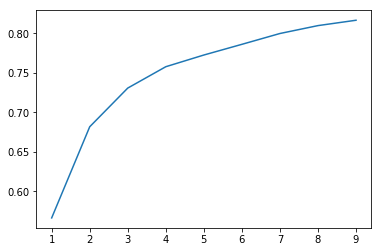

In [6]:
average_IOUs=[]
for num_anchors in range(1,10):
    
    centroids = run_kmeans(annotations, num_anchors)
    avgiou = avg_IOU(annotations, centroids)
    average_IOUs.append(avgiou)
    print('\naverage IOU for', num_anchors, 'anchors:', '%0.2f' % avgiou)
        
    
plt.plot(range(1,10), average_IOUs)

In [4]:

# decide for 5 anchors

# ANCHORS = run_kmeans(annotations, 5)
#np.save(open('anchors5.npy', "w"), ANCHORS)

ANCHORS = np.load(path+'anchors5_41.npy')
print(ANCHORS)


[[1.68299542 1.62364461]
 [1.08045681 0.99582158]
 [1.6224161  2.77864211]
 [1.17440432 1.87737246]
 [1.94299841 3.98515719]]


In [5]:
class generator(Sequence):

    def __init__(self, folder, filenames, anchors, pneumonia_locations=None, class_dict=None, classification=False,
                 batch_size=32, image_size=224, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        self.anchors = anchors
        self.class_dict = class_dict
        self.classification = classification

    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        img = img/255.
        img = equalize_hist(img)
        img = np.repeat(np.expand_dims(img,2),3, axis=2)  
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        filename = filename.split('.')[0]

        if not self.classification:
            grid_w = 7
            grid_h = 7
            output = np.zeros((grid_h,grid_w,5,5))
            true_boxes = np.zeros((1,1,1,10,4))
            # get filename without extension

            # if image contains pneumonia
            if filename in pneumonia_locations:
                # loop through pneumonia
                true_box_index = 0

                for location in pneumonia_locations[filename]:
                    x, y, w, h = np.array(location)*(self.image_size/1024.)
                    c_x = x + 0.5 * w
                    c_x = c_x / (self.image_size/float(grid_w))
                    c_y = y + 0.5 * h
                    c_y = c_y / (self.image_size/float(grid_h))

                    w = w / (self.image_size/float(grid_w))
                    h = h / (self.image_size/float(grid_h))

                    grid_x = int(np.floor(c_x))
                    grid_y = int(np.floor(c_y))

                    box = [c_x, c_y, w, h]

                    best_anchor = -1
                    max_iou     = -1

                    for i in range(len(self.anchors)):
                        iou = IOU(self.anchors[i], [(w,h)])[0]

                        if max_iou < iou:
                            best_anchor = i
                            max_iou = iou

                    output[grid_y, grid_x, best_anchor, 0:4] = box
                    output[grid_y, grid_x, best_anchor, 4] = 1

                    true_boxes[0,0,0, true_box_index] = box
                    true_box_index += 1
                    true_box_index = true_box_index % 10
        else:
            output = self.class_dict[filename]

        

        if not self.classification:
            return [img, true_boxes], output
        return img, output

    def __loadpredict__(self, filename):
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        img = img/255.
        img = equalize_hist(img)
        img = np.repeat(np.expand_dims(img,2),3, axis=2)
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        
        return img

    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and labels
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, outputs = zip(*items)
            if not self.classification:
                imgs, true_boxes = zip(*imgs)
                # create numpy batch
                imgs = np.array(imgs)
                true_boxes = np.array(true_boxes)
                outputs = np.array(outputs)
                return [imgs, true_boxes], outputs

            imgs = np.array(imgs)
            outputs = np.array(outputs)
            return imgs, outputs

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [6]:
pneumonia_locations = {}
# load table
with open(path+'stage_1_train_labels.csv', mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]   

In [7]:
folder = path+'/stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
#split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]

# save for reproducability
# np.save(open(path+'train_filenames.npy', 'w'), train_filenames)
# np.save(open(path+'valid_filenames.npy', 'w'), valid_filenames)

train_filenames = np.load(path+'train_filenames.npy')
valid_filenames = np.load(path+'valid_filenames.npy')

print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))

('n train samples', 23124)
('n valid samples', 2560)


In [8]:
BATCH_SIZE = 8
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 1.0
COORD_SCALE      = 1.0

In [17]:
# prepare data and labels for classification training

data = pd.read_csv(path+'stage_1_detailed_class_info.csv')
data_classes = ['Normal', 'Lung Opacity', 'No Lung Opacity / Not Normal']
class_labels = data['class'].apply(data_classes.index)
class_labels = to_categorical(class_labels, num_classes=3)
class_labels_dict = {data['patientId'][i]:class_labels[i] for i in range(len(class_labels))}

train_gen = generator(folder, train_filenames, ANCHORS, pneumonia_locations,
                     class_dict=class_labels_dict, classification=True,
                     batch_size=BATCH_SIZE, image_size=INPUT_SIZE, shuffle=True, augment=False, predict=False)
valid_gen = generator(folder, valid_filenames, ANCHORS, pneumonia_locations,
                     class_dict=class_labels_dict, classification=True,
                     batch_size=BATCH_SIZE, image_size=INPUT_SIZE, shuffle=False, predict=False)

In [ ]:
# finetune the model Chxnet to classify the images

# Building the model
img_input = Input(shape=(INPUT_SIZE,INPUT_SIZE,3))
base_model = DenseNet121(include_top=False, input_shape=(INPUT_SIZE,INPUT_SIZE,3), input_tensor=img_input, pooling='avg', weights=None)
x = base_model.output
predictions = Dense(14, activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)
model.load_weights(path+'brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

model.layers.pop()

x = model.layers[-1].output
predictions = Dense(3, activation="softmax", name="predictions")(x)

model = Model(inputs=img_input, outputs=predictions)


early_stop = EarlyStopping(monitor='val_loss', 
                          min_delta=0.0001, 
                          patience=5, 
                          mode='min', 
                          verbose=1)

checkpoint = ModelCheckpoint('pneumonia_classification.h5', 
                            monitor='val_loss', 
                            verbose=1, 
                            save_best_only=True, 
                            mode='min', 
                            period=1)

optimizer = Adam(lr=1e-4)
model.compile(loss='categorical_crossentropy',
             metrics=['accuracy'],
             optimizer=optimizer)

history = model.fit_generator(generator = train_gen, 
                   steps_per_epoch  = len(train_gen), 
                   epochs           = 100, 
                   verbose          = 1,
                   validation_data  = valid_gen,
                   validation_steps = len(valid_gen),
                   callbacks        = [early_stop, checkpoint], 
                   )


In [9]:
# prepare the data for detection training

train_gen = generator(folder, train_filenames, ANCHORS, pneumonia_locations,             
                      batch_size=BATCH_SIZE, image_size=INPUT_SIZE, shuffle=True, augment=False, predict=False)
valid_gen = generator(folder, valid_filenames, ANCHORS, pneumonia_locations,                    
                      batch_size=BATCH_SIZE, image_size=INPUT_SIZE, shuffle=False, predict=False)    


In [10]:
def custom_loss(y_true, y_pred):
    
    mask_shape = tf.shape(y_true)[:4]
    grid_w = 7
    grid_h = 7
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(grid_w), [grid_h]), (1, grid_h, grid_w, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    
    mask_shape = tf.shape(y_true)[:4]

    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid

    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,5,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    """
    Determine the masks
    """

    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    

    
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4])
    nb_no_box = tf.reduce_sum(conf_mask[..., 4])
   
    nb_positions = nb_no_box + nb_true_box
    OBJECT_SCALE = tf.truediv(nb_positions, nb_true_box+1e-6)
    NO_OBJECT_SCALE = tf.truediv(nb_positions, nb_no_box+1e-6)
    conf_mask = conf_mask * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE


    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))    
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)  * coord_mask ) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)  * coord_mask ) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.    
    loss = loss_xy + loss_wh + loss_conf
    
    
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.5))
    all_pred_box = tf.reduce_sum(tf.to_float(pred_box_conf > 0.5))
    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [nb_true_box], message='nb_true_box \t', summarize=1000)
    loss = tf.Print(loss, [nb_pred_box], message='nb_pred_box \t', summarize=1000)
    loss = tf.Print(loss, [all_pred_box], message='all_pred_box \t', summarize=1000)

    return loss


In [12]:
# building the YOLO detection model

img_input = Input(shape=(INPUT_SIZE,INPUT_SIZE,3))
true_boxes = Input(shape=(1, 1, 1, 10 , 4))

base_model = DenseNet121(include_top=False, input_shape=(INPUT_SIZE,INPUT_SIZE,3), input_tensor=img_input, pooling='avg', weights=None)
x = base_model.output
predictions = Dense(3, activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)
model.load_weights(path+'pneumonia_classification.h5')

model.layers.pop()
model.layers.pop()

x = model.layers[-1].output
x = Activation('relu')(x)

x = Conv2D(128, 3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, 3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(25, 1, strides=(1,1), padding='valid')(x)
x = AveragePooling2D(2)(x)

output = Reshape((grid_h, grid_w, 5, 5))(x)
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([img_input, true_boxes], output)

only train the new added layers
for layer in model.layers[:-12]:
    layer.trainable = False
    

model.compile(loss=custom_loss, optimizer=optimizer)

history = model.fit_generator(generator = train_gen, 
                    steps_per_epoch  = len(train_gen), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_gen,
                    validation_steps = len(valid_gen),
                    callbacks        = [early_stop, checkpoint], 
                    )

In [20]:
# train the whole model after trsaining the last layers for a sufficient convergence

for layer in model.layers[:-12]:
    layer.trainable = True
    
history = model.fit_generator(generator = train_gen, 
                    steps_per_epoch  = len(train_gen), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_gen,
                    validation_steps = len(valid_gen),
                    callbacks        = [early_stop, checkpoint], 
                    )

In [13]:
### TESTING

## Loading the trained model weights and the corresponding anchors 

model.load_weights(path+'weights_pneumonia_yolo_5a41.h5')
ANCHORS = np.load(path+'anchors5_41.npy')

In [14]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def non_max_suppression_fast(boxes, confidences, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(confidences)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return pick

def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3, image_size=224):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    confidences = []
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 4] *= netout[..., 4] > obj_threshold

    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                confidence = netout[row,col,b,4]

                if confidence > obj_threshold:
                    x, y, w, h = netout[row,col,b,:4]
                    x = (col + _sigmoid(x)) / float(grid_w) * image_size# center position, unit: image width
                    y = (row + _sigmoid(y)) / float(grid_h) * image_size# center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / float(grid_w) * image_size # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / float(grid_h) * image_size# unit: image height
                    
                    box = [int(x-w/2.), int(y-h/2.), int(x+w/2.), int(y+h/2.)]    
                    boxes.append(box)
                    confidences.append(confidence)
    boxes = np.array(boxes)
    confidences = np.array(confidences)
    # suppress non-maximal boxes
    if len(boxes):
        pick = non_max_suppression_fast(boxes, confidences, nms_threshold)
        return boxes[pick], confidences[pick]
    
    return boxes, confidences

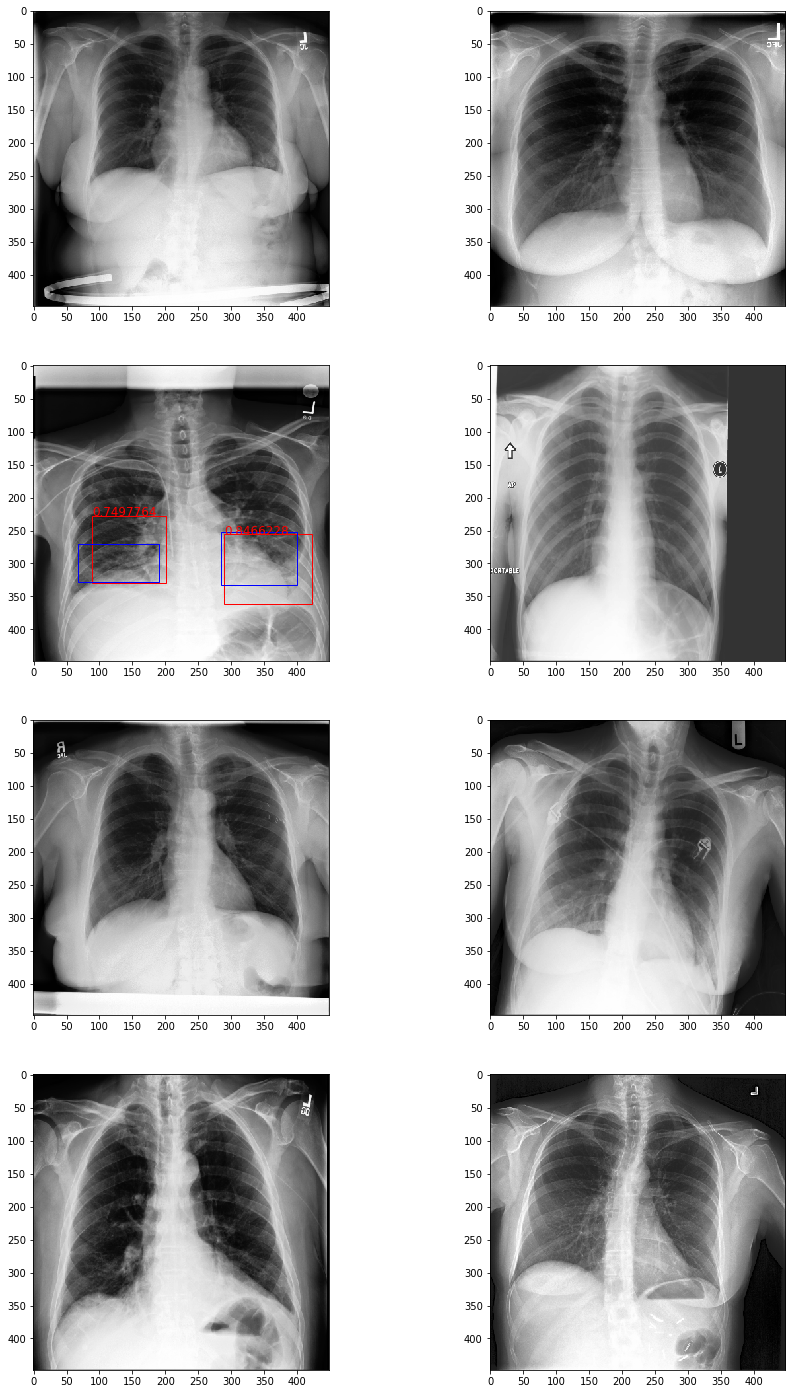

In [21]:
# predicting patches from the validation set.

dummy_array = np.zeros((1,1,1,1,10,4))
for k, (inputs, outputs) in enumerate(valid_gen):
     if k==2:
        imgs = inputs[0]
        f, axarr = plt.subplots(4, 2, figsize=(15,25))
        axarr = axarr.ravel()
        for i in range(len(imgs)):
            
            input_img = np.expand_dims(imgs[i], 0)
            true_boxes = inputs[1][i][0, 0, 0, :, :]*(448/7.)
            netout = model.predict([input_img, dummy_array])
            boxes, confidences = decode_netout(netout[0], 
                           obj_threshold=0.5,
                           nms_threshold=0.1,
                           image_size=448,
                           anchors=ANCHORS.ravel(), 
                           nb_class=1)
            axarr[i].imshow(input_img[0])
            
            if len(boxes):
                for box, confidence in zip(boxes, confidences):
                    x1,y1,x2,y2 = box
                    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
                    axarr[i].add_patch(rect)
                    axarr[i].text(x1, y1, str(confidence), fontsize=12, color='r')

            for box in true_boxes:
                if np.sum(box) > 0:
                    x, y, w, h = box
                    x = int(x-w/2.)
                    y = int(y-h/2.)
                    w = int(w)
                    h = int(h)
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    axarr[i].add_patch(rect)
             
             
 # only plot one batch
        break
     
plt.show()